In [75]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd

In [87]:
rootdir = '/local/data/MPI-SOM_FFN_SOCCOMv2018/'
filename = 'MPI-SOM_FFN_SOCCOMv2018weighted_minus_4uatm_offset.nc'
nds = nc.Dataset(rootdir+filename)
# ds = xr.open_dataset(rootdir+filename)

In [90]:
times = pd.date_range('1982-01-01','2017-12-31',freq='M')
ds = xr.Dataset()
ds['fgco2'] = xr.DataArray(nds['fgco2'][:],dims=['time','lat','lon'])
ds['fgco2'] = ds['fgco2'].where(ds['fgco2']<1E19,np.nan)
# ds['seamask'] = xr.DataArray(nds['seamask'][:],dims=['lat','lon'])
ds = ds.assign_coords({'time':times,'lat':nds['lat'][:],'lon':nds['lon'][:]})

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

In [82]:
# Creating an xgcm grid
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [97]:
gridlon='lon'
gridlat='lat'
ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
xgrid = Grid(ds, periodic=['X'])

# Get horizontal distances
dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
dlatC = xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])

ds['daC'] = ds['dxC']*ds['dyC']

In [102]:
fgco2 = (ds['fgco2']*ds['daC']).sel(lat=slice(-90,-30)).sum(['lat','lon'])
fgco2.name = 'fgco2'
fgco2.to_netcdf('../data/processed/MPI-SOM_FFN_SOCCOMv2018/fgco2_SO_int.nc')

In [72]:
[datetime.datetime(2000,1,1) + datetime.timedelta(seconds=each) for each in ds['time'][:]]
# ds['time']

TypeError: unsupported type for timedelta seconds component: numpy.int32

In [104]:
nds['fgco2']

<class 'netCDF4._netCDF4.Variable'>
float32 fgco2(time, lat, lon)
    long_name: air-sea CO2 flux
    standard_name: air-sea CO2 flux
    units: mol/m2/yr
    FillValue: 1e+20
    missing_value: 1e+20
unlimited dimensions: 
current shape = (432, 180, 360)
filling on, default _FillValue of 9.969209968386869e+36 used

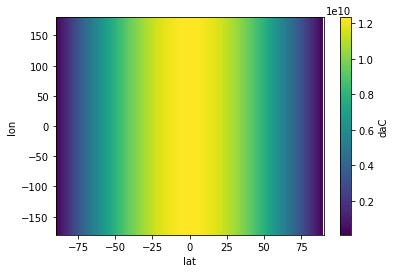

In [98]:
ds['daC'].plot()